In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
import gradio as gr

df = pd.read_csv('data_annon.csv', sep = ';', decimal = ',')

df['fecha'] = pd.to_datetime(df['fecha'])

treatment_date = dt.datetime(2021, 12, 1)

df.head()

,id_mercado,mercado,fecha,anio_mes,anio,mes,quarter,fabricante,pais,id_producto,...,marca_calibre,precio_unitario,precio_hl,volumen_hl,importe,vol_total_hl,som_marca_calibre,som_marca_calibre_perc,flag_val,intervalo
0,372FE8C,mercado_001__MERCADO_TOTAL,2019-09-01,201909,2019,9,3,fabricante_001,9621C07,9619BDB,...,marca_001 - 300ML,,27185.011601,0.5701,15498.175114,103198.1282,5.524325e-06,0.0,1.0,pre_baja_precio
1,372FE8C,mercado_001__MERCADO_TOTAL,2019-10-01,201910,2019,10,4,fabricante_001,9621C07,9619BDB,...,marca_001 - 300ML,,27189.618463,0.1519,4130.103045,104503.7709,1.453536e-06,0.0,1.0,pre_baja_precio
2,372FE8C,mercado_001__MERCADO_TOTAL,2019-09-01,201909,2019,9,3,fabricante_001,9621C07,CB3CF15,...,marca_002 - 355ML,,11485.395417,0.0519,596.092022,103198.1282,5.029161e-07,0.0,1.0,pre_baja_precio
3,372FE8C,mercado_001__MERCADO_TOTAL,2019-09-01,201909,2019,9,3,fabricante_001,9621C07,34F7FF3,...,marca_003 - 1000ML,,5436.605128,1.9664,10690.540323,103198.1282,1.905461e-05,0.0,1.0,pre_baja_precio
4,372FE8C,mercado_001__MERCADO_TOTAL,2019-10-01,201910,2019,10,4,fabricante_001,9621C07,34F7FF3,...,marca_003 - 1000ML,,5436.563657,2.4384,13256.516821,104503.7709,2.333313e-05,0.0,1.0,pre_baja_precio


# Split relevant markets

In [ ]:
filtro_fabricante = df['fabricante'] == 'fabricante_006__AB_IN_BEV'
filtro_marca = df['marca'] == 'marca_028__MARCA_ESTUDIADA'
filtro_mercado = df['mercado'] == 'mercado_006__MERCADO_ESTUDIAR'

mercado_006 = df[filtro_fabricante & filtro_marca & filtro_mercado]
mercado_006 = mercado_006[['fecha', 'precio_hl', 'som_marca_calibre_perc', 'volumen_hl', 'anio', 'mes', 'quarter']]
mercado_006 = mercado_006.groupby('fecha').mean().reset_index()

mercado_006['study_group'] = 1
mercado_006['treatment'] = np.where(mercado_006['fecha'] > treatment_date, 1, 0)

mercado_006.head()

,fecha,precio_hl,som_marca_calibre_perc,volumen_hl,anio,mes,quarter,study_group,treatment
0,2019-09-01,6437.286109,2.174167,709.539375,2019.0,9.0,3.0,1,0
1,2019-10-01,6677.370907,2.463636,700.164927,2019.0,10.0,4.0,1,0
2,2019-11-01,6385.859462,2.640000,526.341555,2019.0,11.0,4.0,1,0
3,2019-12-01,7170.830479,2.980000,835.683450,2019.0,12.0,4.0,1,0
4,2020-01-01,7098.518180,2.861000,1128.009080,2020.0,1.0,1.0,1,0


In [ ]:
filtro_fabricante = df['fabricante'] == 'fabricante_006__AB_IN_BEV'
filtro_marca = df['marca'] == 'marca_028__MARCA_ESTUDIADA'
filtro_mercado = df['mercado'] == 'mercado_004'

mercado_004 = df[filtro_fabricante & filtro_marca & filtro_mercado]
mercado_004 = mercado_004[['fecha', 'precio_hl', 'som_marca_calibre_perc', 'volumen_hl', 'anio', 'mes', 'quarter']]
mercado_004 = mercado_004.groupby('fecha').mean().reset_index()

mercado_004['study_group'] = 0
mercado_004['treatment'] = np.where(mercado_004['fecha'] > treatment_date, 1, 0)

mercado_004.head()

,fecha,precio_hl,som_marca_calibre_perc,volumen_hl,anio,mes,quarter,study_group,treatment
0,2019-09-01,10448.511784,1.554545,221.093400,2019.0,9.0,3.0,0,0
1,2019-10-01,11729.334097,2.376667,303.462011,2019.0,10.0,4.0,0,0
2,2019-11-01,11570.921298,1.902222,173.829444,2019.0,11.0,4.0,0,0
3,2019-12-01,11005.280846,1.632500,194.329200,2019.0,12.0,4.0,0,0
4,2020-01-01,10453.770461,2.080000,331.707763,2020.0,1.0,1.0,0,0


# Plot general trends

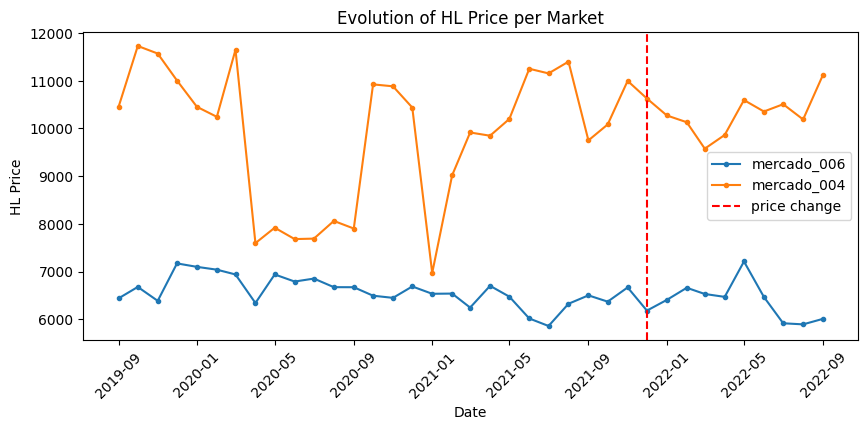

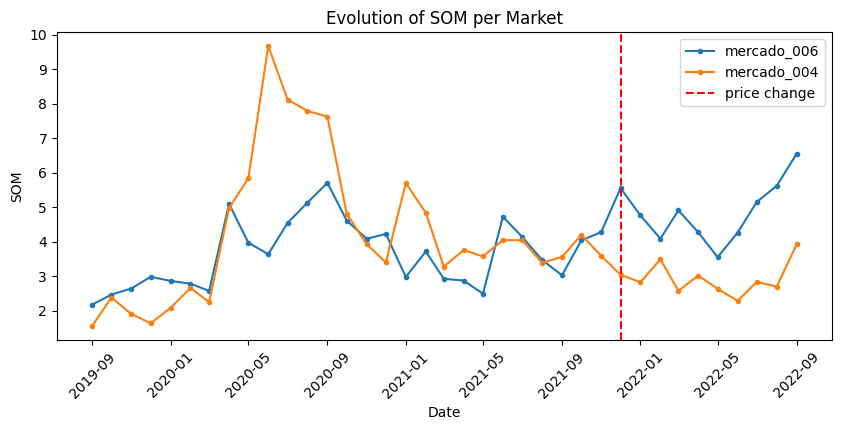

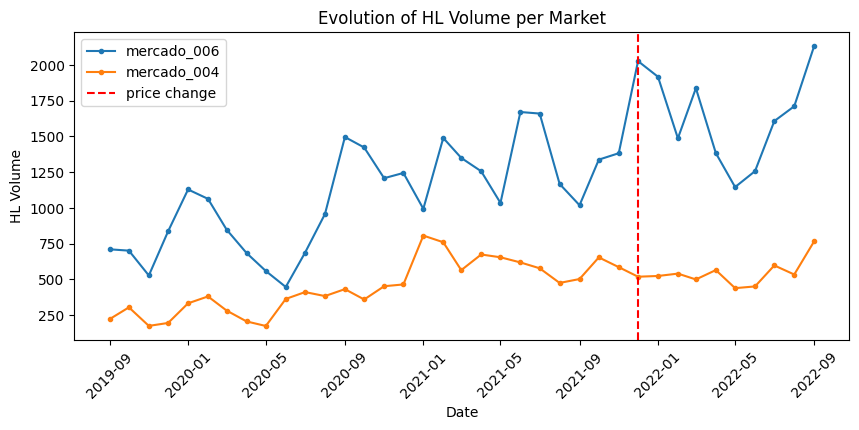

In [ ]:
plt.figure(figsize = (10, 4))
plt.plot(mercado_006['fecha'], mercado_006['precio_hl'], marker = '.', label = 'mercado_006')
plt.plot(mercado_004['fecha'], mercado_004['precio_hl'], marker = '.', label = 'mercado_004')
plt.title('Evolution of HL Price per Market')
plt.ylabel('HL Price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.axvline(treatment_date, color = 'red', linestyle = '--', label = 'price change')
plt.legend()


plt.figure(figsize = (10, 4))
plt.plot(mercado_006['fecha'], mercado_006['som_marca_calibre_perc'], marker = '.', label = 'mercado_006')
plt.plot(mercado_004['fecha'], mercado_004['som_marca_calibre_perc'], marker = '.', label = 'mercado_004')
plt.title('Evolution of SOM per Market')
plt.ylabel('SOM')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.axvline(treatment_date, color = 'red', linestyle = '--', label = 'price change')
plt.legend()


plt.figure(figsize = (10, 4))
plt.plot(mercado_006['fecha'], mercado_006['volumen_hl'], marker = '.', label = 'mercado_006')
plt.plot(mercado_004['fecha'], mercado_004['volumen_hl'], marker = '.', label = 'mercado_004')
plt.title('Evolution of HL Volume per Market')
plt.ylabel('HL Volume')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.axvline(treatment_date, color = 'red', linestyle = '--', label = 'price change')
plt.legend()

# Difference-in-Differences


SOM_MARCA_CALIBRE_PERC
                              OLS Regression Results                              
Dep. Variable:     som_marca_calibre_perc   R-squared:                       0.765
Model:                                OLS   Adj. R-squared:                  0.693
Method:                     Least Squares   F-statistic:                     10.71
Date:                    Wed, 07 Jun 2023   Prob (F-statistic):           5.26e-12
Time:                            11:55:15   Log-Likelihood:                -82.050
No. Observations:                      74   AIC:                             200.1
Df Residuals:                          56   BIC:                             241.6
Df Model:                              17                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

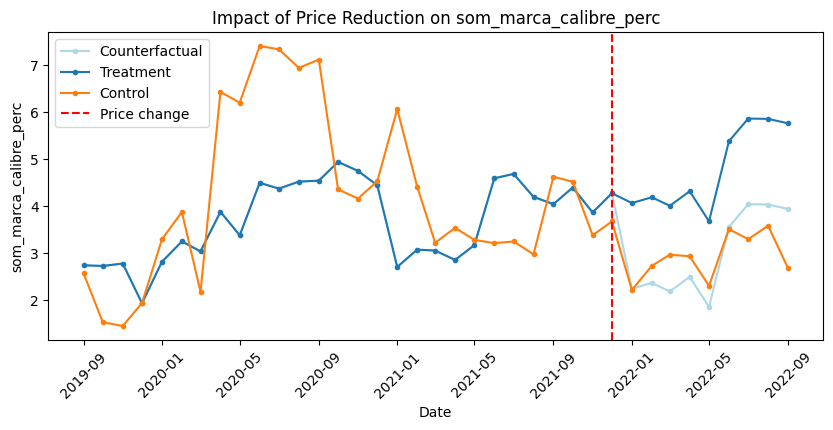

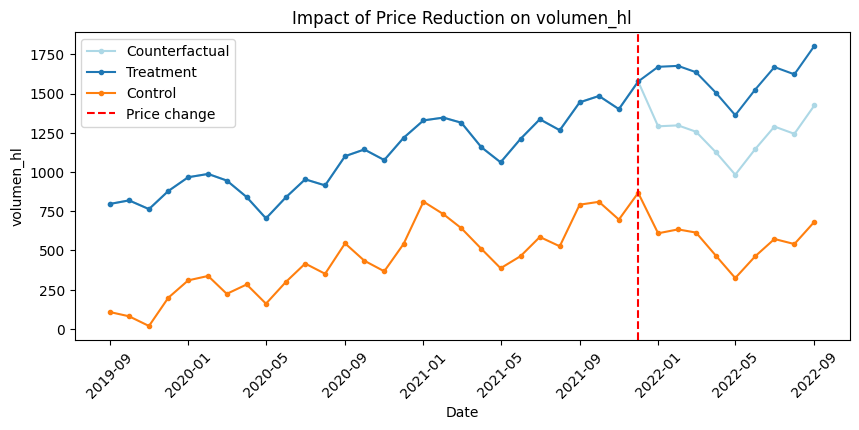

In [ ]:
X = pd.concat([mercado_006, mercado_004])

for target in ['som_marca_calibre_perc', 'volumen_hl']:
    
    print('\n' + target.upper())
    
    # establish equation to fit
    control = 'precio_hl + C(anio) + C(mes) + C(quarter)'
    equation = f'{target} ~ study_group + treatment + study_group * treatment + {control}'
    
    # instantiate smf 
    model = smf.ols(formula = equation, data = X)   
    
    # fit
    results = model.fit()
    
    # print results
    print(results.summary())
    
    # gather coefficients
    params = results.params
    b0 = params['Intercept']
    b1 = params['study_group']
    b2 = params['treatment']
    b3 = params['study_group:treatment']
    
    # generate series
    X['pred'] = results.predict(X)
    X['counterfactual'] = X['pred'] - b3 * X['study_group'] * X['treatment']

    # create some filters
    filter_treatment = X['treatment'] == 1
    filter_group = X['study_group'] == 1

    # plot
    plt.figure(figsize = (10, 4))
    plt.plot(X[filter_group]['fecha'], X[filter_group]['counterfactual'], label = 'Counterfactual', color = 'lightblue', marker = '.') 
    plt.plot(X[filter_group]['fecha'], X[filter_group]['pred'], label = 'Treatment', color = 'C0', marker = '.') 
    plt.plot(X[~filter_group]['fecha'], X[~filter_group]['pred'], label = 'Control', color = 'C1', marker = '.') 
    plt.axvline(treatment_date, color = 'red', linestyle = '--', label = 'Price change')
    plt.title(f'Impact of Price Reduction on {target}')
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.xticks(rotation = 45)
    plt.legend(loc = 0)


# Simple Difference

                            OLS Regression Results                            
Dep. Variable:      som_marca_calibre   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     1.813
Date:                Wed, 07 Jun 2023   Prob (F-statistic):              0.103
Time:                        11:55:16   Log-Likelihood:                 168.66
No. Observations:                  37   AIC:                            -305.3
Df Residuals:                      21   BIC:                            -279.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0280      0.01

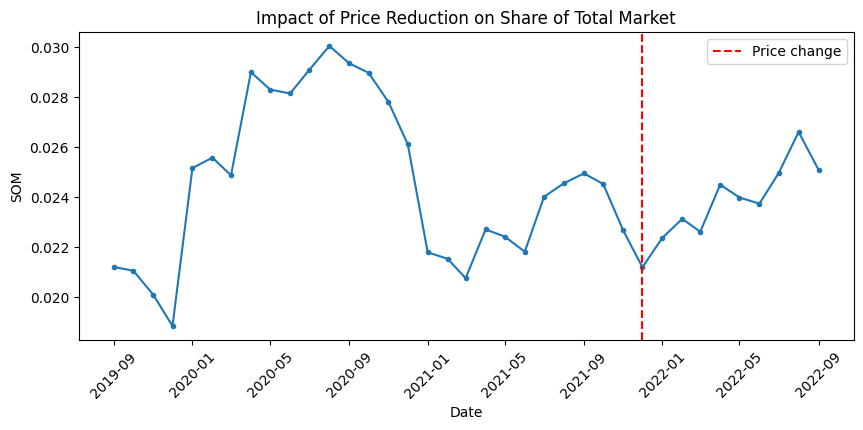

In [ ]:
filtro_mercado_total = df['mercado'] == 'mercado_001__MERCADO_TOTAL'

X = df[filtro_fabricante & filtro_marca & filtro_mercado_total]
X = X[['fecha', 'precio_hl', 'som_marca_calibre', 'volumen_hl', 'anio', 'mes', 'quarter']]
X['treatment'] = np.where(X['fecha'] > treatment_date, 1, 0)
X = X.groupby('fecha').mean().reset_index()

# target
target = 'som_marca_calibre'

# establish equation to fit
control = 'precio_hl + C(anio) + C(mes) + C(quarter)'
equation = f'{target} ~ treatment + {control}'

# instantiate smf 
model = smf.ols(formula = equation, data = X)   

# fit
results = model.fit()

# print results
print(results.summary())

# generate series
X['pred'] = results.predict(X)

# filter
filter_treatment = X['treatment'] == 1

# plot
plt.figure(figsize = (10, 4))
plt.plot(X['fecha'], X['pred'], marker = '.')
plt.axvline(treatment_date, color = 'red', linestyle = '--', label = 'Price change')
plt.title(f'Impact of Price Reduction on Share of Total Market')
plt.ylabel('SOM')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.legend()

# Correlations

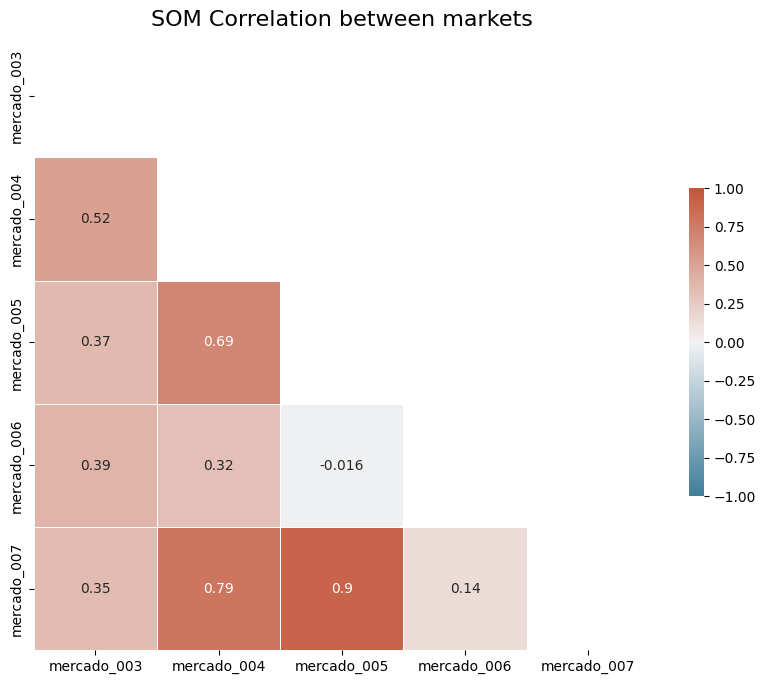

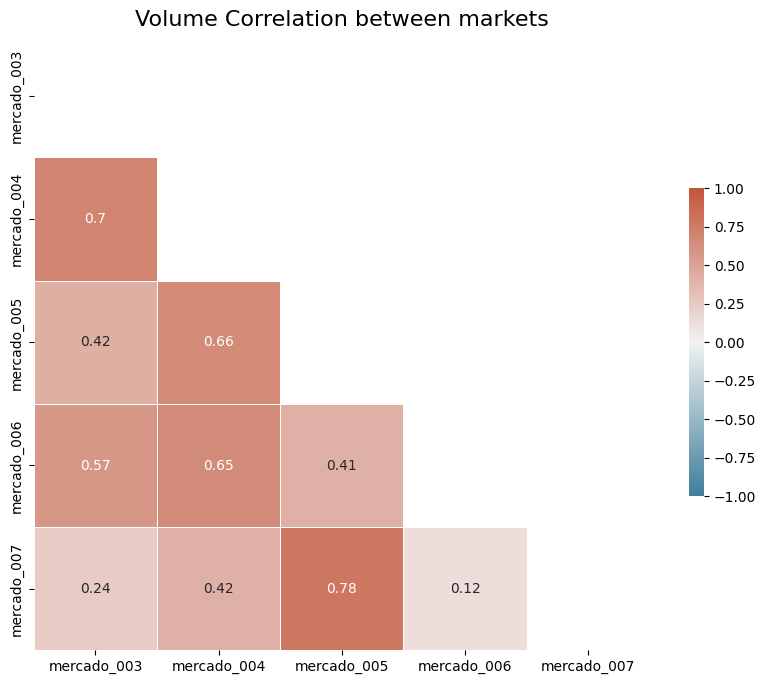

In [ ]:
def plot_corr(serie, title):
    
    dataframe = df[filtro_fabricante & filtro_marca]

    mercado_003 = dataframe[dataframe['mercado'] == 'mercado_003']
    mercado_003 = mercado_003[['fecha', serie]].groupby('fecha').mean().rename(columns = {serie: 'mercado_003'})

    mercado_004 = dataframe[dataframe['mercado'] == 'mercado_004']
    mercado_004 = mercado_004[['fecha', serie]].groupby('fecha').mean().rename(columns = {serie: 'mercado_004'})

    mercado_005 = dataframe[dataframe['mercado'] == 'mercado_005']
    mercado_005 = mercado_005[['fecha', serie]].groupby('fecha').mean().rename(columns = {serie: 'mercado_005'})

    mercado_006 = dataframe[dataframe['mercado'] == 'mercado_006__MERCADO_ESTUDIAR']
    mercado_006 = mercado_006[['fecha', serie]].groupby('fecha').mean().rename(columns = {serie: 'mercado_006'})

    mercado_007 = dataframe[dataframe['mercado'] == 'mercado_007']
    mercado_007 = mercado_007[['fecha', serie]].groupby('fecha').mean().rename(columns = {serie: 'mercado_007'})

    corr = pd.concat([mercado_003, mercado_004, mercado_005, mercado_006, mercado_007], axis = 1).corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 8))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin = -1, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title, fontsize = 16)
    plt.show()
    
plot_corr('som_marca_calibre_perc', 'SOM Correlation between markets')
plot_corr('volumen_hl', 'Volume Correlation between markets')

# Forecast

## Holdout

### SOM

In [ ]:
data = mercado_004[['fecha', 'som_marca_calibre_perc', 'precio_hl']].rename(columns = {'fecha': 'ds', 'som_marca_calibre_perc': 'y'}).copy() # prepare data

# holdout
data_train = data[data['ds'] <= treatment_date] 
data_test = data[data['ds'] > treatment_date]

# init model
model = Prophet()

# we add price as regressor
model.add_regressor('precio_hl')

# fit
model.fit(data_train)

# predict
forecast = model.predict(data_test)
y_pred = forecast['yhat']

# print MAE
mae_test = mean_absolute_error(y_pred=y_pred, y_true=data_test['y'])
print(f'MAE on test data: {mae_test:.4f}')

11:55:17 - cmdstanpy - INFO - Chain [1] start processing
11:55:17 - cmdstanpy - INFO - Chain [1] done processing


MAE on test data: 1.3757


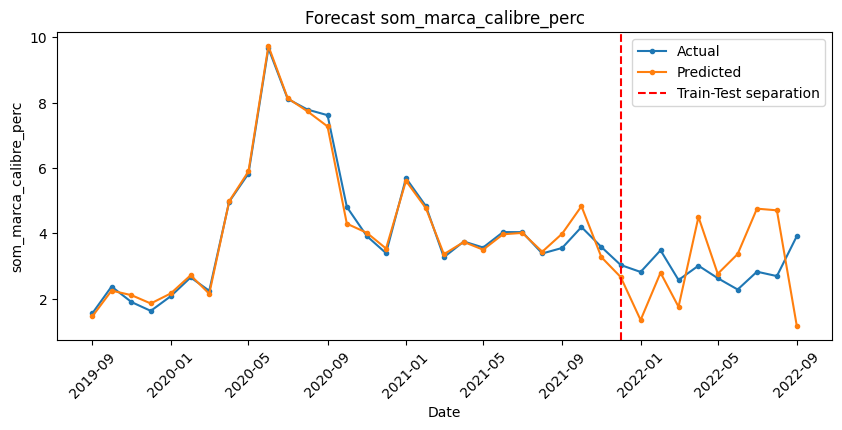

In [ ]:
forecast = model.predict(data)
y_pred = forecast['yhat']

# plot
plt.figure(figsize = (10, 4))
plt.plot(forecast['ds'], data['y'], label = 'Actual', marker = '.')
plt.plot(forecast['ds'], y_pred, label = 'Predicted', marker = '.')
plt.axvline(treatment_date, color = 'red', linestyle = '--', label = 'Train-Test separation')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('som_marca_calibre_perc')
plt.title('Forecast som_marca_calibre_perc')
plt.legend()

### Volumen

In [ ]:
data = mercado_004[['fecha', 'volumen_hl', 'precio_hl']].rename(columns = {'fecha': 'ds', 'volumen_hl': 'y'}).copy() # prepare data

# holdout
data_train = data[data['ds'] <= treatment_date]
data_test = data[data['ds'] > treatment_date]

# init model
model = Prophet()

# we add price as regressor
model.add_regressor('precio_hl')

# fit
model.fit(data_train)

# predict
forecast = model.predict(data_test)
y_pred = forecast['yhat']

# print MAE
mae_test = mean_absolute_error(y_pred=y_pred, y_true=data_test['y'])
print(f'MAE on test data: {mae_test:.4f}')

11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing


MAE on test data: 288.9504


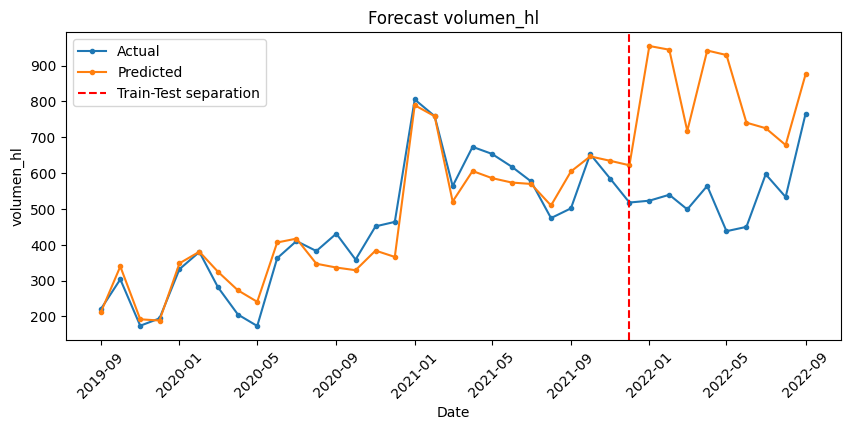

In [ ]:
forecast = model.predict(data)
y_pred = forecast['yhat']

plt.figure(figsize = (10, 4))
plt.plot(forecast['ds'], data['y'], label = 'Actual', marker = '.')
plt.plot(forecast['ds'], y_pred, label = 'Predicted', marker = '.')
plt.axvline(treatment_date, color = 'red', linestyle = '--', label = 'Train-Test separation')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('volumen_hl')
plt.title('Forecast volumen_hl')
plt.legend()

## Train and export

In [ ]:
# SOM
# train on full data
data = mercado_004[['fecha', 'som_marca_calibre_perc', 'precio_hl']].rename(columns = {'fecha': 'ds', 'som_marca_calibre_perc': 'y'}).copy() # prepare data

data.to_csv('demo/ab_challenge/data/som_data.csv', encoding = 'utf-8-sig', sep = ';', index = False)

# initiate model
model = Prophet()

# we add price as regressor
model.add_regressor('precio_hl')

# fit
model.fit(data)

# save model
with open('demo/ab_challenge/models/som_model.json', 'w') as fout:
    fout.write(model_to_json(model))  # Save model
    
    
# VOLUME    
# train on full data
data = mercado_004[['fecha', 'volumen_hl', 'precio_hl']].rename(columns = {'fecha': 'ds', 'volumen_hl': 'y'}).copy() # prepare data

data.to_csv('demo/ab_challenge/data/volumen_data.csv', encoding = 'utf-8-sig', sep = ';', index = False)

# initiate model
model = Prophet()

# we add price as regressor
model.add_regressor('precio_hl')

# fit
model.fit(data)

# save model
with open('demo/ab_challenge/models/volumen_model.json', 'w') as fout:
    fout.write(model_to_json(model))  # Save model

11:55:19 - cmdstanpy - INFO - Chain [1] start processing
11:55:19 - cmdstanpy - INFO - Chain [1] done processing
11:55:19 - cmdstanpy - INFO - Chain [1] start processing
11:55:19 - cmdstanpy - INFO - Chain [1] done processing
